# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle
import lightkurve as lk
from astropy.io import fits
from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import arviz as az

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# System parameters

In [4]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=470987100
epoch_tess = ufloat(2459601.239901, 0.002775)
period_tess = ufloat(4.1192231192586, 0.0000142968365)
depth_tess = ufloat(1236.5042452328, 93.31554) # ppm
duration_tess = ufloat(2.1841674568197, 0.5088356)  # hours
radius_tess = ufloat(2.2236629223564, 1.6888051) # R_earth
insolation_tess = 44.245826205857 # S_earth

stteff_tess = ufloat(3876, 157)
strad_tess = ufloat(0.632571, 0.0187445)
stmass_tess = ufloat(0.613891, 0.0202526)

In [5]:
lk.search_lightcurve('TIC 470987100')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 20,2019,SPOC,120,470987100,0.0
1,TESS Sector 20,2019,TESS-SPOC,1800,470987100,0.0
2,TESS Sector 20,2019,QLP,1800,470987100,0.0
3,TESS Sector 47,2021,SPOC,120,470987100,0.0
4,TESS Sector 47,2021,TESS-SPOC,600,470987100,0.0
5,TESS Sector 47,2021,QLP,600,470987100,0.0
6,TESS Sector 60,2022,SPOC,120,470987100,0.0
7,TESS Sector 60,2022,TESS-SPOC,200,470987100,0.0
8,TESS Sector 60,2022,QLP,200,470987100,0.0


In [6]:
sr = lk.search_lightcurve('TIC 470987100', author='SPOC', exptime=120)
sr.table["dataURL"] = sr.table["dataURI"]  # workaround MAST issue
lcc = sr.download_all(flux_column="pdcsap_flux")
lc = lcc.stitch().remove_nans().normalize().remove_outliers()

time = lc.time.value
flux = lc.flux

with fits.open(lcc[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64) 

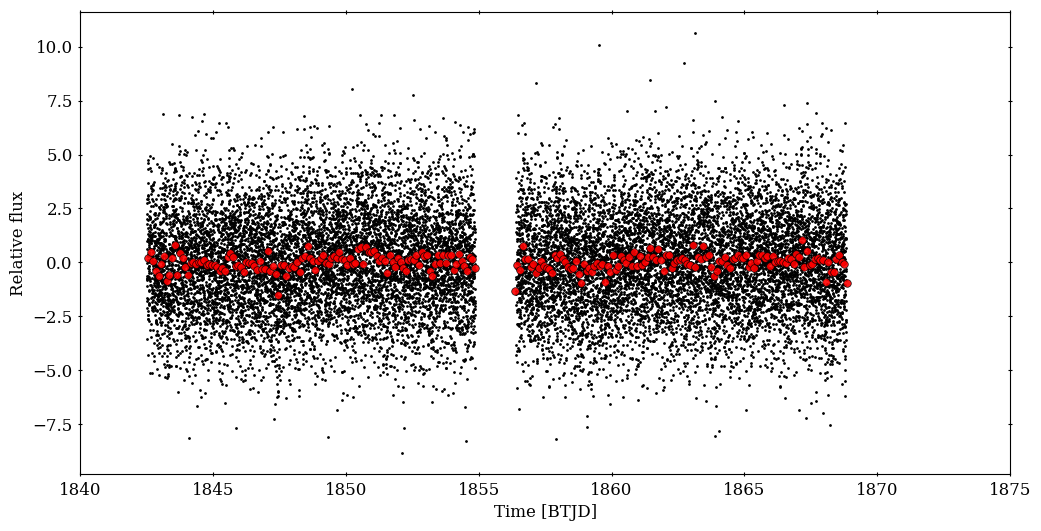

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(time, y_, "o", color='k', markersize=1)
lcc = lk.LightCurve(time=time, flux=y_)
lcc_binned = lcc.bin(time_bin_size=0.1, time_bin_start=lcc.time.value.min(), time_bin_end=lcc.time.value.max())
plt.scatter(lcc_binned['time'].value, lcc_binned['flux'].value, marker='o', s=30,  edgecolors='k', 
                linewidths=0.5, c='r', alpha=0.9, zorder=12)
plt.xlim(1840,1875)
plt.xlabel("Time [BTJD]")
plt.ylabel("Relative flux")
#plt.savefig('tess_sector.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

(-7.199999999999999, 7.199999999999999)

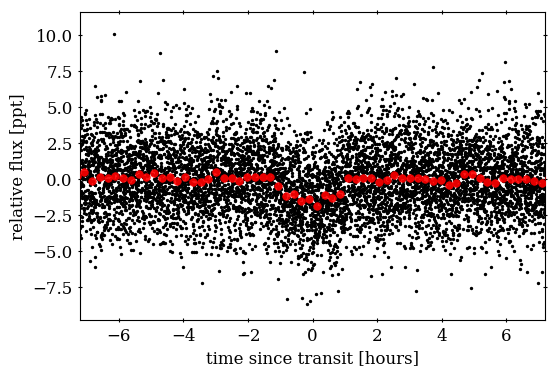

In [8]:
t0_tess = epoch_tess.n-2457000-ref_time
x_fold2 =  (x_ - t0_tess + 0.5 * period_tess.n) % period_tess.n - 0.5 * period_tess.n

x = x_
y = y_
yerr = yerr_
x_fold = x_fold2

plt.scatter(x_fold*24, y, c='k', s=2)
lcc = lk.LightCurve(time=x_fold, flux=y, flux_err=yerr)
lcc_binned = lcc.bin(time_bin_size=0.01, time_bin_start=lcc.time.value.min(), time_bin_end=lcc.time.value.max())
plt.scatter(lcc_binned['time'].value*24, lcc_binned['flux'].value, marker='o', s=30,  edgecolors='r', 
                linewidths=0.5, c='r', alpha=0.9, zorder=12)
plt.xlabel("time since transit [hours]")
plt.ylabel("relative flux [ppt]")
plt.xlim(-0.3*24, 0.3*24)
#plt.savefig('tess_sector_fold.png', dpi=300, facecolor='w', bbox_inches='tight')

# RV reading

In [9]:
lbl_gl410 = pd.read_table('./lbl_toi1732_gl410/lbl_TOI1732_GL410.rdb', sep=None, engine='python', header=0)
lbl_gl846 = pd.read_table('./lbl_toi1732_gl846/lbl_TOI1732_GL846.rdb', sep=None, engine='python', header=0)
lbl_toi1732 = pd.read_table('./lbl_toi1732_toi1732/lbl_TOI1732_TOI1732.rdb', sep=None, engine='python', header=0)

lbl2_gl410 = pd.read_table('./lbl_toi1732_gl410/lbl2_TOI1732_GL410.rdb', sep=None, engine='python', header=0)
lbl2_gl846 = pd.read_table('./lbl_toi1732_gl846/lbl2_TOI1732_GL846.rdb', sep=None, engine='python', header=0)
lbl2_gl846_new = pd.read_table('./new_montreal/lbl2_TOI1732_GL846_bervzp.rdb', sep=None, engine='python', header=0)

lbl2_gl699_car = pd.read_table('./lbl2_carmona/lbl2_TOI1732_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl699_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI1732_GL699_Vtot10corr.rdb', sep='\s+', engine='python', header=0)

lbl2_gl905_car = pd.read_table('./lbl2_carmona/lbl2_TOI1732_GL905.rdb', sep=None, engine='python', header=0)
lbl2_gl905_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI1732_GL905_Vtot10corr.rdb', sep='\s+', engine='python', header=0)

lbl2_toi1732_car = pd.read_table('./lbl2_carmona/lbl2_TOI1732_TOI1732.rdb', sep=None, engine='python', header=0)
lbl2_toi1732_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI1732_TOI1732_Vtot10corr.rdb', sep='\s+', engine='python', header=0)

#names = ['lbl_gl410', 'lbl_gl846', 'lbl_toi1732']
names = ['lbl2_gl846', 'lbl2_gl846_new']
#names = ['lbl2_gl699_car', 'lbl2_gl905_car', 'lbl2_toi1732_car']
#names = ['lbl2_gl699_car_vtot10', 'lbl2_gl905_car_vtot10', 'lbl2_toi1732_car_vtot10']

star_name = 'toi1732'

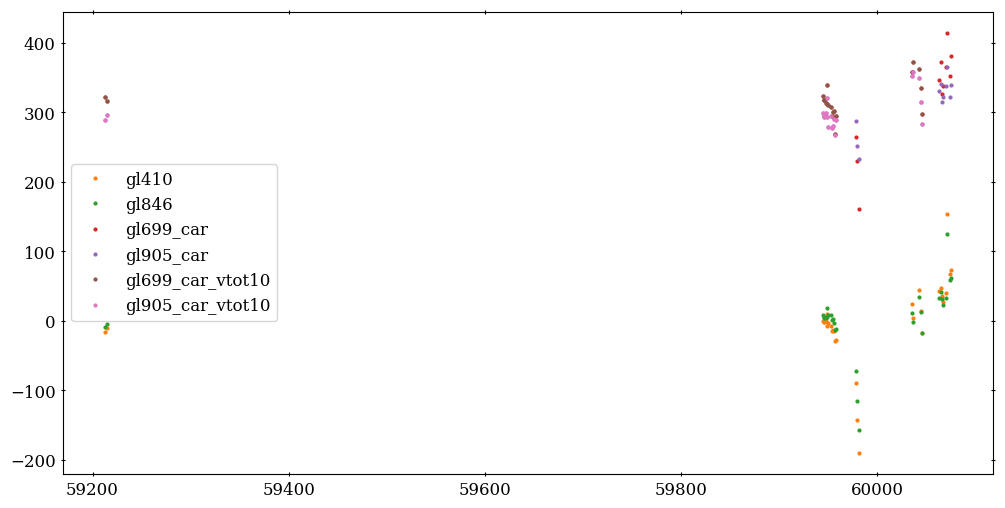

In [10]:
# plot all the datasets vrad vs rjd
plt.figure(figsize=(12, 6))
# plt.plot(lbl_gl410['rjd'], lbl_gl410['vrad'], 'o', color='k', markersize=1, label='gl410')
# plt.plot(lbl_gl846['rjd'], lbl_gl846['vrad'], 'o', color='r', markersize=1, label='gl846')
plt.plot(lbl2_gl410['rjd'], lbl2_gl410['vrad']-np.mean(lbl2_gl410['vrad']), 'o', color='C1', markersize=2, label='gl410')
plt.plot(lbl2_gl846['rjd'], lbl2_gl846['vrad']-np.mean(lbl2_gl410['vrad']), 'o', color='C2', markersize=2, label='gl846')
plt.plot(lbl2_gl699_car['rjd'], lbl2_gl699_car['vrad']-np.mean(lbl2_gl410['vrad']), 'o', color='C3', markersize=2, label='gl699_car')
plt.plot(lbl2_gl905_car['rjd'], lbl2_gl905_car['vrad']-np.mean(lbl2_gl410['vrad']), 'o', color='C4', markersize=2, label='gl905_car')
plt.plot(lbl2_gl699_car_vtot10['rjd'], lbl2_gl699_car_vtot10['vrad']-np.mean(lbl2_gl410['vrad']), 'o', color='C5', markersize=2, label='gl699_car_vtot10')
plt.plot(lbl2_gl905_car_vtot10['rjd'], lbl2_gl905_car_vtot10['vrad']-np.mean(lbl2_gl410['vrad']), 'o', color='C6', markersize=2, label='gl905_car_vtot10')
plt.legend(loc='best')
#plt.xlim(59930, 60100)

In [11]:
print(len(lbl_gl410), len(lbl_gl846), len(lbl2_gl410), len(lbl2_gl846), len(lbl_toi1732), len(lbl2_gl699_car), len(lbl2_gl905_car), len(lbl2_toi1732_car), len(lbl2_gl699_car_vtot10), len(lbl2_gl905_car_vtot10), len(lbl2_toi1732_car_vtot10))

118 118 31 31 118 31 31 31 20 20 20


In [12]:
#datasets = list([lbl_gl410, lbl_gl846, lbl_toi1732])
datasets = list([lbl2_gl846, lbl2_gl846_new])
#datasets = list([lbl2_gl699_car, lbl2_gl905_car, lbl2_toi1732_car])
#datasets = list([lbl2_gl699_car_vtot10, lbl2_gl905_car_vtot10, lbl2_toi1732_car_vtot10])

In [13]:
datasets[0][datasets[0]['rjd']>59850]

,rjd,vrad,svrad,d2v,sd2v,d3v,sd3v,DTEMP,sDTEMP,local_file_name,...,vrad_2080nm,svrad_2080nm,vrad_2167nm,svrad_2167nm,vrad_2257nm,svrad_2257nm,vrad_2351nm,svrad_2351nm,vrad_2449nm,svrad_2449nm
2,59944.061961,-15488.503345,4.374738,49457.422617,10994.892280,-1.986694e+07,2.089870e+07,154.378543,1.252982,2837606o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15395.038897,26.347554,-15417.996223,40.061984,-15567.013391,40.151138,-15538.118239,23.781240,-15584.624007,54.416293
3,59945.078676,-15492.671250,4.375234,47787.680266,11005.468073,-3.409946e+07,2.091409e+07,149.642181,1.252899,2837798o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15380.737910,27.258714,-15434.397900,39.740079,-15670.305996,41.283288,-15506.323142,23.154907,-15553.614921,52.294387
4,59946.039269,-15491.006069,4.246346,93595.028677,10690.176327,-3.084563e+07,2.033120e+07,156.349211,1.218726,2837989o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15362.084700,26.078118,-15517.876824,38.789973,-15562.678235,38.383606,-15537.010848,21.621720,-15452.555071,46.361336
5,59947.079575,-15491.645083,4.451612,172021.367865,11207.462140,-5.062550e+07,2.135065e+07,158.207153,1.267360,2838183o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15433.330961,26.867721,-15505.589224,40.815172,-15594.190317,38.443185,-15492.321015,22.702050,-15443.449542,48.357325
6,59948.104543,-15478.344391,4.205472,129018.158424,10602.520362,-2.150632e+06,2.011289e+07,157.540196,1.188741,2838354o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15437.259427,26.288523,-15470.328369,37.838153,-15585.162551,37.889655,-15489.780194,21.032481,-15483.758224,45.351291
7,59949.064083,-15490.660792,4.059840,129161.983214,10244.682695,-6.499067e+06,1.944758e+07,153.033594,1.135466,2838519o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15408.784261,26.473055,-15532.131022,40.019912,-15591.020077,34.101303,-15491.630607,18.730151,-15516.707167,38.794702
8,59950.079131,-15487.500010,4.432455,181325.638126,11161.412412,4.185949e+06,2.120317e+07,158.710581,1.243790,2838698o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15368.388466,26.889104,-15457.249173,39.036749,-15608.732756,35.916820,-15503.209476,19.657902,-15448.214424,43.782275
9,59953.091410,-15488.075950,5.262990,170921.406886,13192.018847,-3.727443e+07,2.518854e+07,162.997128,1.477351,2839160o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15376.096808,30.104895,-15572.945897,46.413748,-15555.481961,43.946001,-15512.902303,24.767668,-15400.069227,58.265829
10,59954.053136,-15495.410476,4.443526,213041.910157,11179.964390,-4.001813e+07,2.127845e+07,153.472349,1.245974,2839337o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15488.030727,26.748189,-15539.961229,39.420991,-15554.591734,35.889379,-15510.837685,20.310890,-15461.228040,47.586225
11,59955.005250,-15493.996814,4.294039,143883.302457,10798.371367,-3.083492e+07,2.052300e+07,152.022737,1.189962,2839505o_pp_e2dsff_tcorr_AB_TOI1732_GL846_lbl....,...,-15475.385972,25.740509,-15530.675062,39.444094,-15542.700034,35.558967,-15505.925454,20.297576,-15467.540821,46.789813


In [14]:
# remove all the points between the rjd range [59977.0, 59982.0] and [600070.0, 60071.0]
for i, data in enumerate(datasets):
    datasets[i] = data[(data['rjd'] > 59850.0)]
# lbl_gl410 = lbl_gl410[(lbl_gl410['rjd'] < 59977.0) | (lbl_gl410['rjd'] > 59982.0)]
# lbl_gl410 = lbl_gl410[(lbl_gl410['rjd'] < 60070.0) | (lbl_gl410['rjd'] > 60071.0)]
# lbl_gl410 = lbl_gl410[(lbl_gl410['rjd'] > 59850.0)]

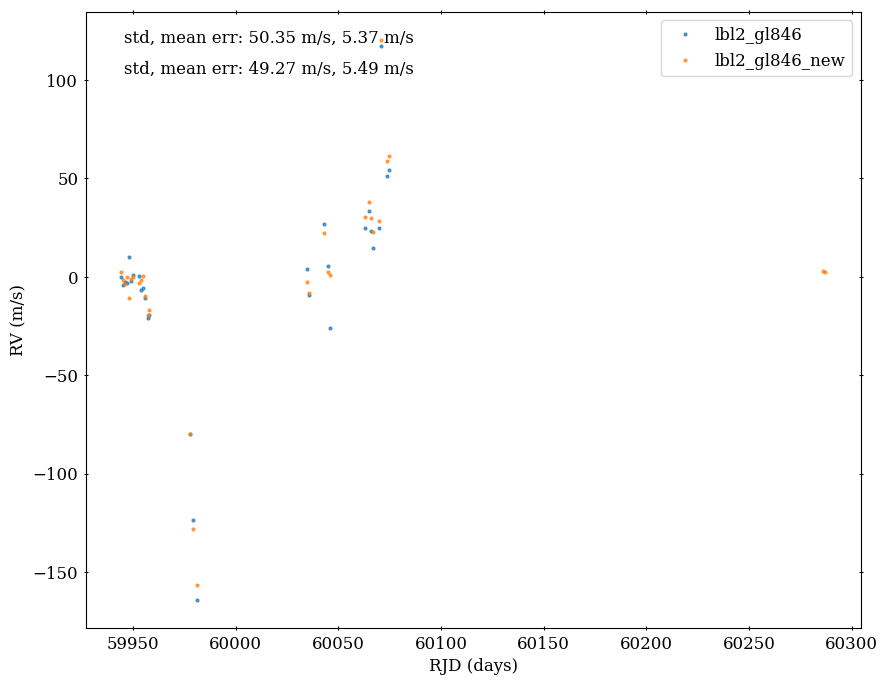

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.savefig('rvs_'+star_name+'.png', dpi=300, facecolor='w')
#plt.xlim(60000, 60125)
plt.show()

## outliers?

In [16]:
for i in range(len(datasets)):
    print(datasets[i].shape)

(29, 172)
(31, 185)


In [17]:
outliers = []
for k, data in enumerate(datasets):
    sigmas = 3
    datasets[k] = data[np.abs(data['vrad'] - data['vrad'].mean()) <= (sigmas * data['vrad'].std())].reset_index(drop=True)
    a = np.abs(data['vrad'] - data['vrad'].mean()) <= (3 * data['vrad'].std())
    outliers.append(np.size(a) - np.count_nonzero(a))
print(outliers)

[1, 1]


In [18]:
# substract the systemic velocity 
for i in datasets:
    i['vrad'] = i['vrad'].apply(lambda x: x - i['vrad'].median())

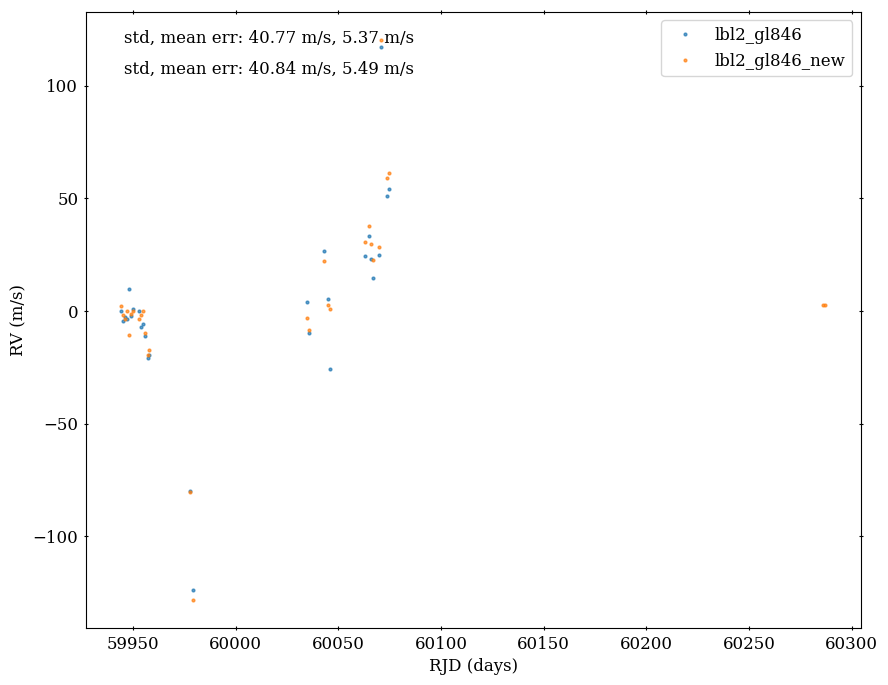

In [19]:
# replot without outliers
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.show()

# GLS

In [20]:
ls = dict()
frequency = dict()
power = dict()
faps = dict()

for k, data in enumerate(datasets):
    ls[k] = LombScargle(data['rjd'], data['vrad'], data['svrad'])
    frequency[k], power[k] = ls[k].autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
    probabilities = [0.01]
    faps[k] = ls[k].false_alarm_level(probabilities)

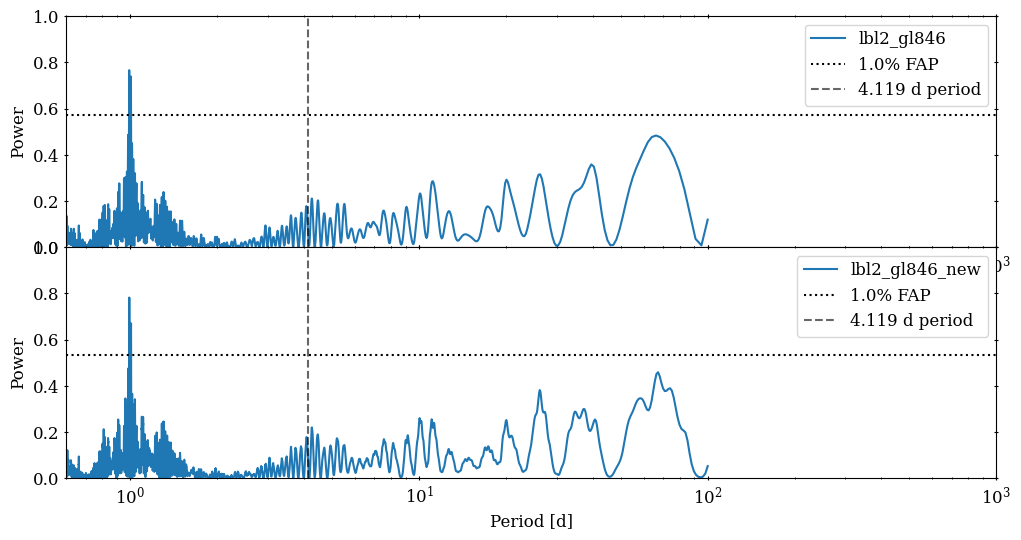

In [21]:
fig, axes = plt.subplots(len(datasets), 1, sharex=False, figsize=(12, 3*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(len(datasets)):
    axes[i].plot(1/frequency[i], power[i], label=names[i])
    axes[i].axhline(faps[i], ls=':', color='black', label='{}% FAP'.format(probabilities[0]*100))
    axes[i].set_xscale('log')
    axes[i].set_xlim(0.6, 1000)
    axes[i].set_ylim(0, 1.0)
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Period [d]')
    axes[i].axvline(period_tess.n, ls='--', color='black', alpha=0.6, label='{} d period'.format(round(period_tess.n, 3)))
    axes[i].legend(loc='upper right')
    axes[i].set_ylim(0, 1)
plt.savefig('gls.png', dpi=300, facecolor='w')

# RV fit 

In [22]:
x_ref = dict()
maxrv = dict()
Kest = dict()

for k, data in enumerate(datasets):
    x_ref[k] = 0.5 * (data['rjd'].min() + data['rjd'].max())
    maxrv[k] = np.std(data['vrad'])*2
    Kest[k] = xo.estimate_semi_amplitude(period_tess.n, data['rjd'], data['vrad'], data['svrad'], t0s=epoch_tess.n-2400000)
    print('Kest: ', Kest[k])
    print(maxrv[k])
    

Kest:  [-0.46221468]
81.54122679268738
Kest:  [2.13925094]
81.68660601134214


In [23]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t = dict()

for k, data in enumerate(datasets):
    t[k] = np.linspace(data['rjd'].min() - 5, data['rjd'].max() + 5, 3000)

    with pm.Model() as model[k]:
        logP = pm.Normal("logP", mu=np.log(period_tess.n), sd=period_tess.s/period_tess.n) #period_tess.s/period_tess.n
        P = pm.Deterministic("P", tt.exp(logP))
        K = pm.Uniform("K", lower=0, upper=maxrv[k])
        # logK = pm.Normal("logK", mu=np.log(Kest[k].item()), sd=2.0, testval=np.log(Kest[k].item()))
        # K = pm.Deterministic("K", tt.exp(logK))

        logs = pm.Normal("logs", mu=np.log(np.median(data['svrad'])), sd=5.0)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
        mstar = BoundedNormal("mstar", mu=stmass_tess.n, sd=stmass_tess.s)
        rstar = BoundedNormal("rstar", mu=strad_tess.n, sd=strad_tess.s)

        t0 = pm.Normal("t0", mu=epoch_tess.n-2400000, sd=epoch_tess.s)

        orbit = xo.orbits.KeplerianOrbit(period=P, 
                                        t0=t0, 
                                        r_star=rstar, 
                                        m_star=mstar)

        # derive mass and semi-major axis
        m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)

        # Define the RVs at the observed times
        rv_model = get_rv_model(data['rjd'])
        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t[k], name="_pred")

        # Finally add in the observation model. 
        err = tt.sqrt(np.asarray(data['svrad'])**2  + tt.exp(2 * logs))
        pm.Normal("obs", mu=rv_model, sd=err, observed=data['vrad'])

In [24]:
for i in range(len(datasets)):
    with model[i]:
        map_soln = pmx.optimize(start=model[i].test_point)
        #map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
        map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Optimization terminated successfully.
logp: -782.6841850970081 -> -122.89496777971146
optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Optimization terminated successfully.
logp: -122.89496777971146 -> -122.89496777971146


optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -804.2056500639461 -> -134.62896870942265
optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.


logp: -134.62896870942265 -> -134.62896870941674


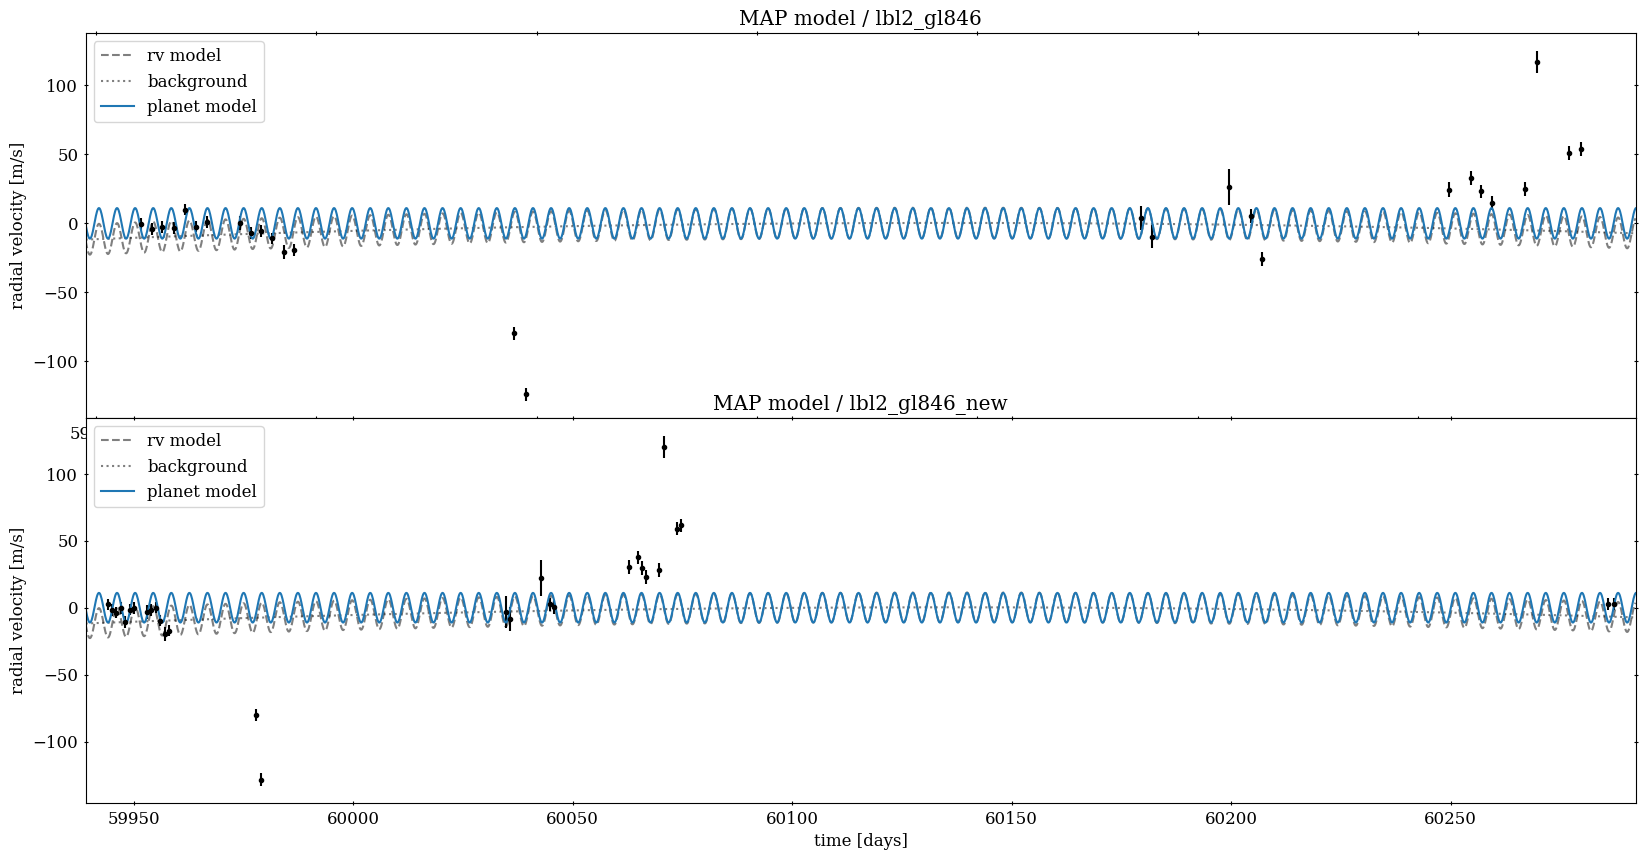

In [25]:
fig, ax = plt.subplots(len(datasets), 1, figsize=(20, 5*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for k, data in enumerate(datasets):
    ax[k].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k")
    ax[k].plot(t[k], map_soln["rv_model_pred"], "--k", alpha=0.5, label='rv model')
    ax[k].plot(t[k], map_soln["bkg_pred"], ":k", alpha=0.5, label="background")
    ax[k].plot(t[k], map_soln["vrad_pred"], label="planet model")

    ax[k].legend(loc="upper left")
    ax[k].set_xlim(t[k].min(), t[k].max())
    ax[k].set_xlabel("time [days]")
    ax[k].set_ylabel("radial velocity [m/s]")
    _ = ax[k].set_title("MAP model"+' / '+names[k])

# Sampling

In [26]:
traces = dict()
for k, data in enumerate(datasets):
    with model[k]:
        traces[k] = pmx.sample(
            tune=2000,
            draws=2000,
            cores=2,
            chains=2,
            target_accept=0.95,
            return_inferencedata=True,
        )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, rstar, mstar, trend, logs, K, logP]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, rstar, mstar, trend, logs, K, logP]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [27]:
summary = dict()
for k, data in enumerate(datasets):
    summary[k] = az.summary(traces[k], stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                var_names=[
                    't0', 'logP', 'P', 'K', 'logs', 'trend', 'mstar', 'rstar', 'm_pl', 'a'
                    ])
    print(summary[k].ess_bulk.mean(), summary[k].ess_tail.mean(), summary[k].r_hat.max())


4557.808970583334 2827.183483833334 1.00188
4012.389609999999 2635.716729416666 1.001148


In [28]:
summary[0]

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,5.960124e+04,2.793000e-03,5.960123e+04,5.960125e+04,3.900000e-05,2.800000e-05,5160.391169,2553.216802,1.001880,5.960124e+04,2.793000e-03
logP,1.415665e+00,4.000000e-06,1.415654e+00,1.415675e+00,0.000000e+00,0.000000e+00,4180.320908,2870.422345,1.000158,1.415664e+00,4.000000e-06
P,4.119223e+00,1.400000e-05,4.119180e+00,4.119267e+00,0.000000e+00,0.000000e+00,4180.320908,2870.422345,1.000161,4.119223e+00,1.400000e-05
K,6.485930e+00,5.567197e+00,1.650000e-03,2.815130e+01,8.161700e-02,5.842400e-02,3032.381111,1855.174822,1.000139,5.035276e+00,5.566501e+00
logs,3.626089e+00,1.555510e-01,3.135175e+00,4.114107e+00,2.180000e-03,1.554000e-03,5143.702611,3333.689116,1.000064,3.621661e+00,1.555320e-01
trend[0],3.324000e-03,2.418000e-03,-4.202000e-03,1.031900e-02,3.400000e-05,2.800000e-05,5111.757228,2821.321402,1.000931,3.353000e-03,2.418000e-03
trend[1],1.455590e-01,8.541000e-02,-1.225540e-01,3.747840e-01,1.149000e-03,8.960000e-04,5540.562046,3153.335332,1.001353,1.474440e-01,8.540000e-02
trend[2],-1.234530e-01,9.879970e-01,-3.043653e+00,2.903634e+00,1.385900e-02,1.442300e-02,5065.703483,3524.849628,0.999695,-1.190890e-01,9.878740e-01
mstar,6.136460e-01,2.035300e-02,5.497750e-01,6.694700e-01,2.990000e-04,2.120000e-04,4597.482077,2952.526955,1.001156,6.136560e-01,2.035000e-02
rstar,6.322740e-01,1.866000e-02,5.824110e-01,6.892610e-01,2.630000e-04,1.860000e-04,5036.435286,3136.754502,0.999935,6.320720e-01,1.865800e-02


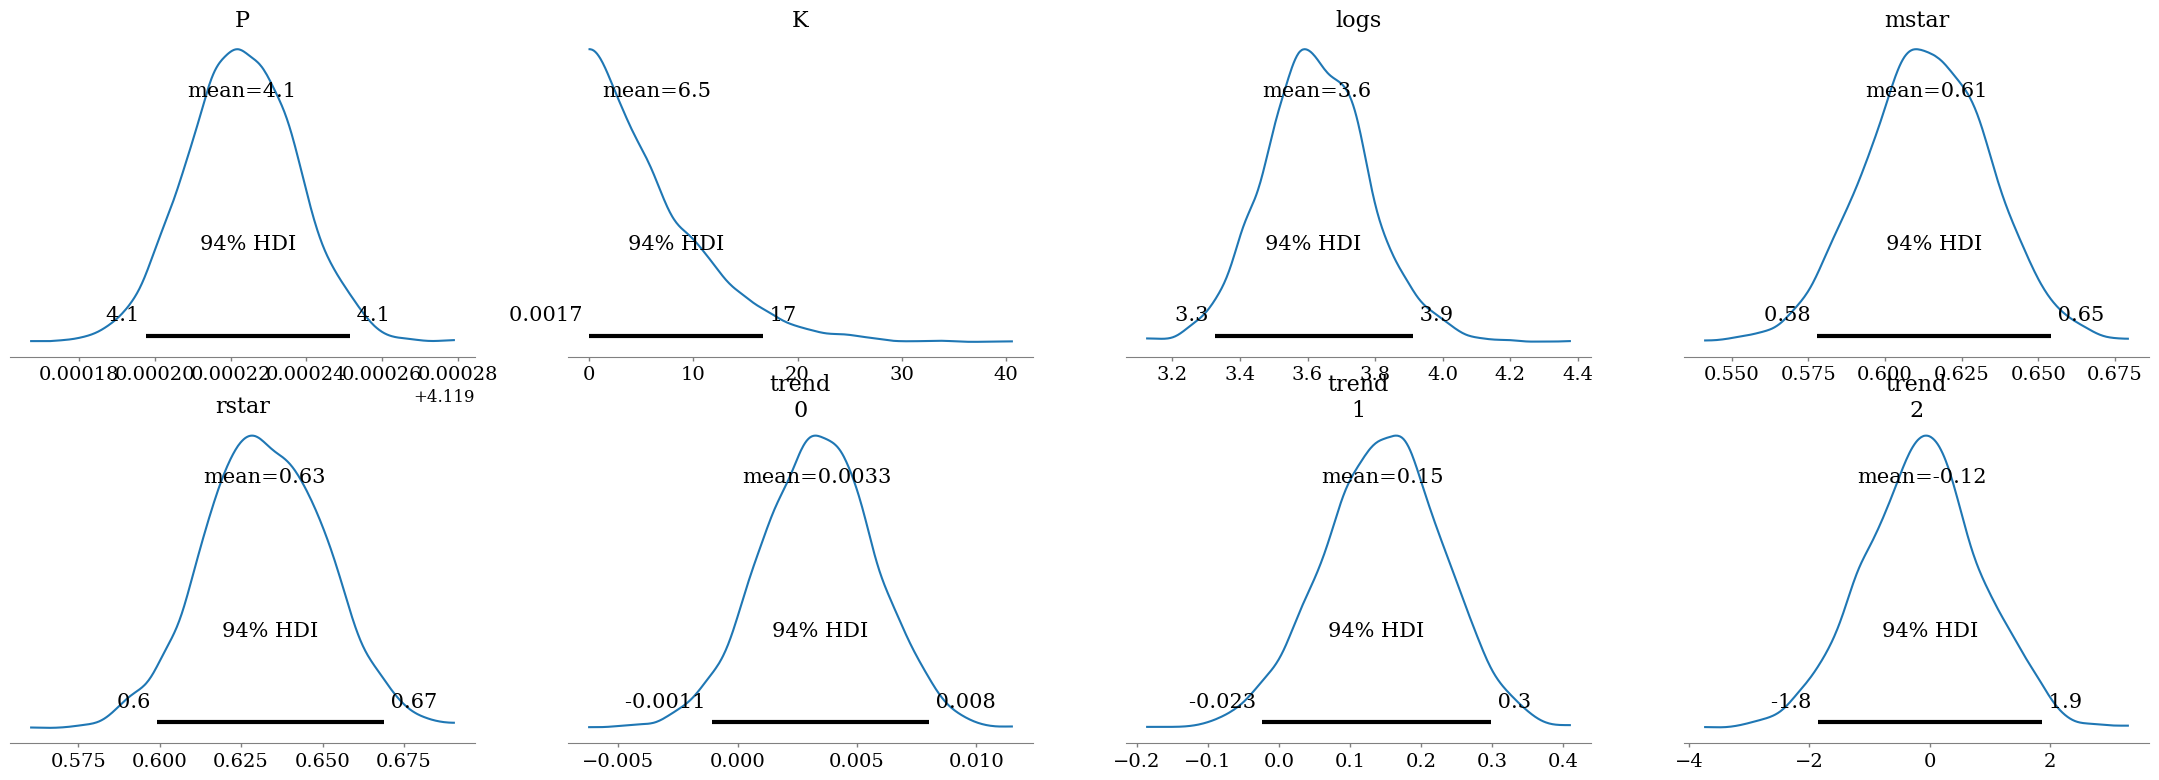

In [29]:
az.plot_posterior(traces[0], var_names=['P', 'K', 'logs', 'mstar', 'rstar', 'trend'])
plt.show()

## Results

In [30]:
mass = dict()
K = dict()
period = dict()
t_0 = dict()
m_star = dict()
r_star = dict()
smaxis = dict()
rv_jitter_ = dict()
bkg_ = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
flat_samps = dict()

for i in range(len(datasets)):
    mass[i] = ufloat((traces[i].posterior["m_pl"].median().item()*u.kg).to(u.M_earth).value, (traces[i].posterior["m_pl"].std().item()*u.kg).to(u.M_earth).value)
    K[i] = ufloat(traces[i].posterior["K"].median().item(), traces[i].posterior["K"].std().item())
    period[i] = ufloat(traces[i].posterior['P'].median().item(),traces[i].posterior['P'].std().item())
    t_0[i] = ufloat(traces[i].posterior['t0'].median().item(), traces[i].posterior['t0'].std().item())
    m_star[i] = ufloat(traces[i].posterior['mstar'].median().item(), traces[i].posterior['mstar'].std().item())
    r_star[i] = ufloat(traces[i].posterior['rstar'].median().item(), traces[i].posterior['rstar'].std().item())
    smaxis[i] = ufloat(traces[i].posterior['a'].median().item(), traces[i].posterior['a'].std().item())
    logsigma_rv = ufloat(traces[i].posterior["logs"].median().item(), traces[i].posterior["logs"].std().item())
    rv_jitter_[i] = np.e**logsigma_rv
    flat_samps[i] = traces[i].posterior.stack(sample=("chain", "draw"))
    bkg_[i] = np.median(flat_samps[i]['bkg'].values, axis=-1)
    rv_model[i] = np.median(flat_samps[i]['rv_model'].values, axis=-1)

    rv_model_pred[i] = np.median(flat_samps[i]['rv_model_pred'].values, axis=-1)
    rv_model_pred_[i] = np.percentile(traces[i].posterior["rv_model_pred"].values,[16, 50, 84], axis=(0, 1))

    print('REDUCTION: ', names[i])
    print("Mp = {m:.3f} Mearth".format(m=mass[i]))
    print('K = {k:.3f} m/s'.format(k=K[i]))
    print("P = {p:.6f} days".format(p=period[i]))
    print("Epoch = {e:.5f}".format(e=t_0[i]))
    print('a = {a:.4f} AU'.format(a=smaxis[i]))
    print('mstar = {m:.3f} Msun'.format(m=m_star[i]))
    print('rstar = {r:.3f} Rsun'.format(r=r_star[i]))
    print("RV jitter = ", rv_jitter_[i])
    print('---------------------------------------------')

REDUCTION:  lbl2_gl846
Mp = 9.132+/-10.086 Mearth
K = 5.035+/-5.567 m/s
P = 4.119223+/-0.000014 days
Epoch = 59601.23997+/-0.00279
a = 0.0427+/-0.0005 AU
mstar = 0.614+/-0.020 Msun
rstar = 0.632+/-0.019 Rsun
RV jitter =  37+/-6
---------------------------------------------
REDUCTION:  lbl2_gl846_new
Mp = 14.829+/-13.738 Mearth
K = 8.204+/-7.588 m/s
P = 4.119223+/-0.000014 days
Epoch = 59601.23991+/-0.00284
a = 0.0427+/-0.0005 AU
mstar = 0.614+/-0.020 Msun
rstar = 0.633+/-0.019 Rsun
RV jitter =  42+/-6
---------------------------------------------


## Plot results

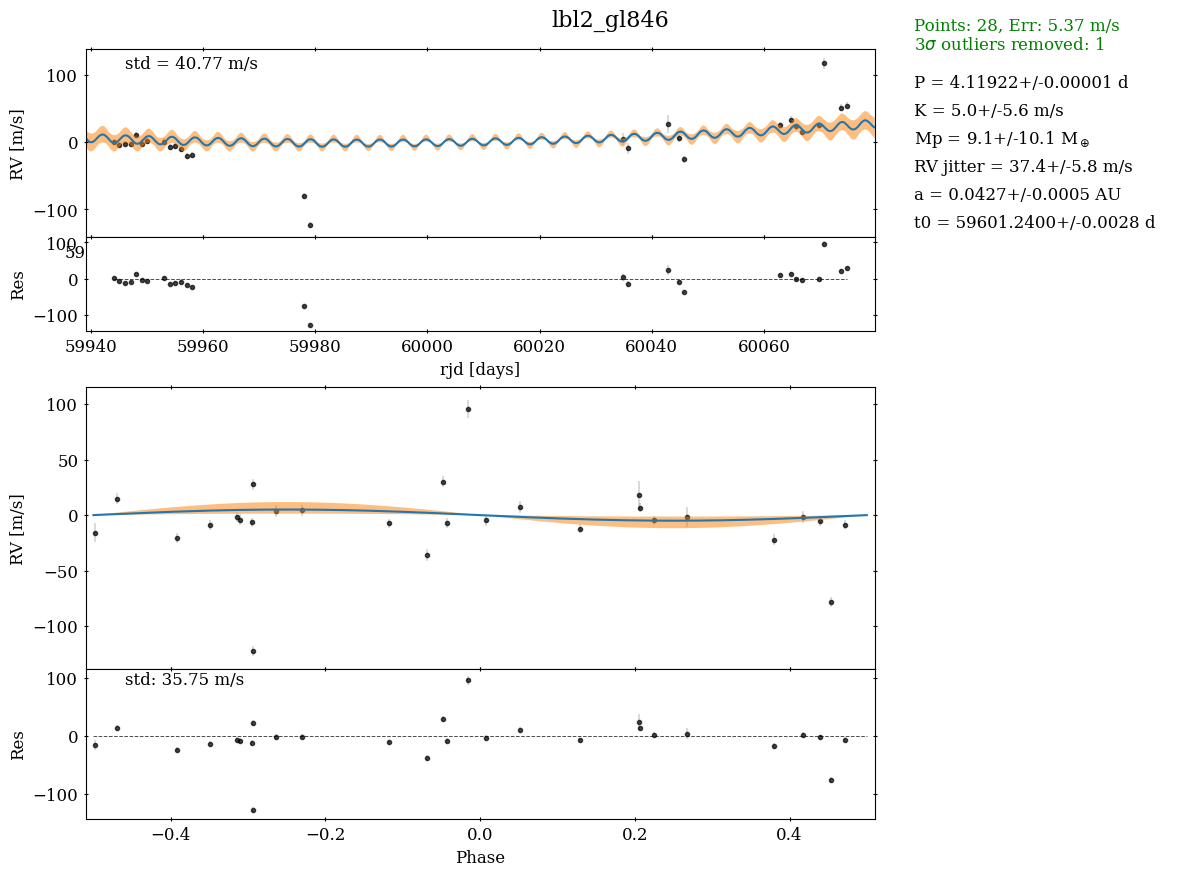

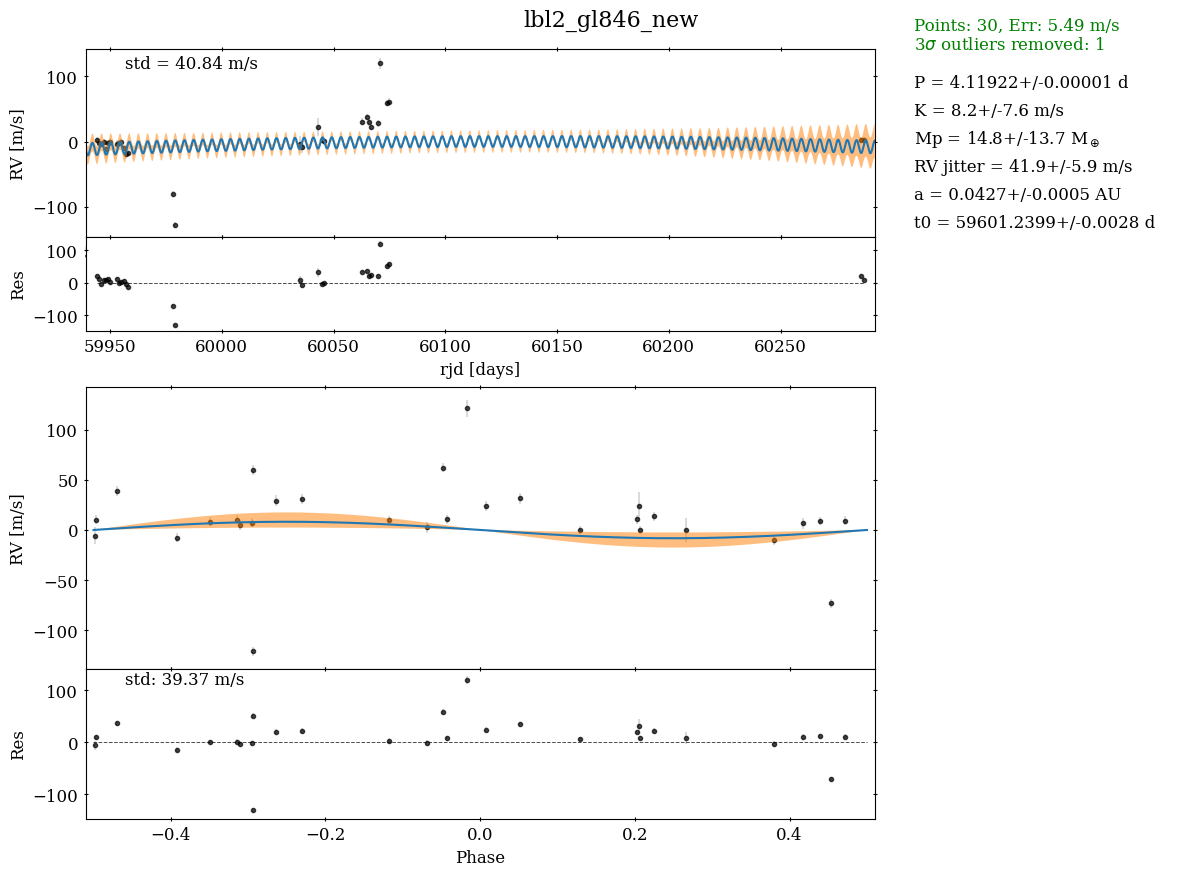

In [31]:
# make a grid of 3 subplots in a column
gs_kw = dict(width_ratios=[4,1], height_ratios=[1, 0.5, 0.3, 1.5, 0.8], hspace=0.0)

for k, data in enumerate(datasets):
    fig, ax = plt.subplots(5, 2, figsize=(14, 10), gridspec_kw=gs_kw)
    fig.suptitle(names[k], y=0.92, fontsize=16)
    # delete the three empty subplots and add the parameters in text
    for i in range(5):
        ax[i,1].xaxis.set_visible(False)
        ax[i,1].yaxis.set_visible(False)
        ax[i,1].spines['left'].set_visible(False)
        ax[i,1].spines['right'].set_visible(False)
        ax[i,1].spines['top'].set_visible(False)
        ax[i,1].spines['bottom'].set_visible(False)
        if i==0 or i==3:
            ax[i,0].set_xticks([])
            ax[i,0].set_xticklabels([])

    ax[0,1].text(-0.3, 1.1, 'Points: {o}, Err: {r:.2f} m/s'.format(o=len(data['vrad']), r=np.mean(data['svrad'])), fontsize=12, color='g')
    ax[0,1].text(-0.3, 1, '3$\sigma$ outliers removed: {o}'.format(o=outliers[k]), fontsize=12, color='g')
    ax[0,1].text(-0.3, 0.8, 'P = {p:.5f} d'.format(p=period[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.65, 'K = {k:.1f} m/s'.format(k=K[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.5, 'Mp = {m:.1f} M$_\oplus$'.format(m=mass[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.35, 'RV jitter = {j:.1f} m/s'.format(j=rv_jitter_[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.2, 'a = {a:.4f} AU'.format(a=smaxis[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.05, 't0 = {t:.4f} d'.format(t=t_0[k]), fontsize=12)
    
    # plot the RVs and the model in the first subplot
    ax[0,0].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k", label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[0,0].plot(t[k], rv_model_pred_[k][1], label='model')
    art = ax[0,0].fill_between(t[k], rv_model_pred_[k][0], rv_model_pred_[k][2], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[0,0].set_ylabel("RV [m/s]")

    # add initial dispersion
    ax[0,0].text(0.05, 0.90, 'std = {s:.2f} m/s'.format(s=np.std(data['vrad'])), fontsize=12, transform=ax[0,0].transAxes)
    ax[0,0].sharex(ax[1,0])
    # add the residuals in the second subplot
    ax[1,0].hlines(0, data['rjd'].min(), data['rjd'].max(), ls='--', lw=0.7, alpha=0.7, color='k')
    ax[1,0].errorbar(data['rjd'], data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[1,0].set_xlim(data['rjd'].min()-5, data['rjd'].max()+5)
    ax[1,0].set_xlabel("rjd [days]")
    ax[1,0].set_ylabel("Res")
    # plot the folded data
    x_fold = (data['rjd'] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    ax[3,0].errorbar(x_fold/period[k].n, data['vrad']-bkg_[k], yerr=data['svrad'], fmt=".k",
                markeredgecolor='k', ecolor='k', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
    # delete the third subplot so it shows as a gap
    ax[2,0].set_visible(False)

    # compute the posterior prediction for the folded RV model
    t_fold = (t[k] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    inds = np.argsort(t_fold)
    pred_rvs = np.percentile(traces[k].posterior["vrad_pred"].values,[16, 50, 84], axis=(0, 1))
    ax[3,0].plot(t_fold[inds]/period[k].n, pred_rvs[1][inds], label='folded model')
    art = ax[3,0].fill_between(t_fold[inds]/period[k].n, pred_rvs[0][inds], pred_rvs[2][inds], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[3,0].set_ylabel("RV [m/s]")

    # plot the residuals
    ax[4,0].hlines(0, -0.5, 0.5, ls='--', lw=0.7, alpha=0.7, color='k')
    ax[4,0].errorbar(x_fold/period[k].n, data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[4,0].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax[4,0].set_ylabel("Res")
    ax[4,0].set_xlabel("Phase")
    # show the std of the residuals
    ax[4,0].text(0.05, 0.90, 'std: '+str(round(np.std(data['vrad']-rv_model[k]), 2))+' m/s', transform=ax[4,0].transAxes)
    ax[4,0].set_xlim(-0.51, 0.51)
    ax[4,0].set_xticks([-0.40, -0.20, 0, 0.40, 0.20])
    ax[3,0].sharex(ax[4,0])
    # savefig with name
    plt.savefig('fit_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

# Limit mass

In [32]:
def limit_mass(K, ecc, period, m_star):
    return K*np.sqrt(1-ecc**2)*(period*u.day.to(u.second)*(m_star*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3)*u.kg.to(u.M_earth)

# compute the mass upper limit from 3 sigma upper limit on K
Ks = np.percentile(traces[1].posterior["K"].values,[0.015, 50, 99.85], axis=(0, 1))
limit_mass(Ks[2], 0.0, period[1], stmass_tess.n).n

72.16987590968952